In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
# make the plots bigger
plt.rcParams["figure.figsize"] = (10,10)

# Image segmentation 

Segmentation is the process of separating pieces out of the whole. In computer vision this tends to refer to separating groups of pixels and grouping them together.       
Segmentation is useful because it allows us to say "this is a ball" and "this is a square". There are many things that fall under segmentation in general, but here we will cover the one provided by OpenCV `findContours` function. 

Contours can be a bit difficult to explain because on face-value they look kind of like what edge detection algorithms do. However, they are indeed more powerful, because instead of an bitmap image, denoting a kind of a map of pixels that belong to an edge, contours provide us with the edge boundaries and their relationship to other boundaries.        
This makes a big difference because it allows us to test the properties of these objects. 

For now, let's quickly whip up an example of edges:

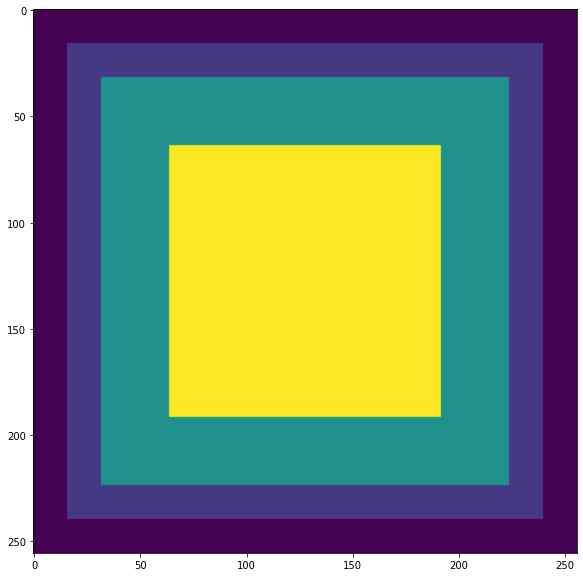

In [3]:
from scipy import ndimage

img = np.zeros((256, 256), dtype=np.uint8)
img[64:-64, 64:-64] += 3
img[32:-32, 32:-32] += 2
img[16:-16, 16:-16] += 1
plt.imshow(img)

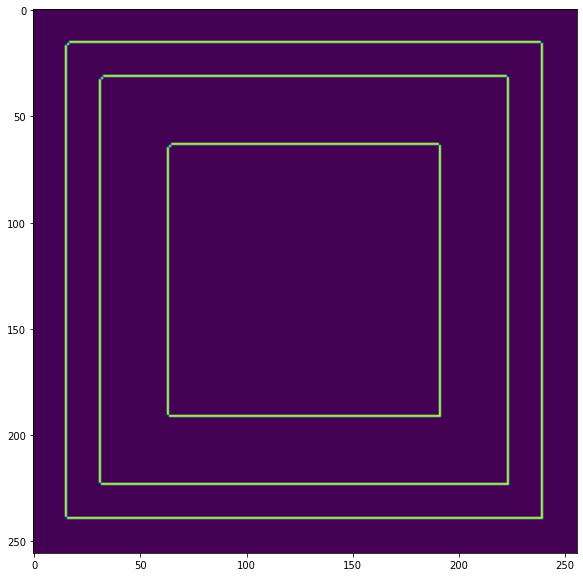

In [4]:
edges = cv2.Canny(img, 0, 1)
plt.imshow(edges)

# Contours

Everything you could possibly want to learn about contours can be found here: https://docs.opencv.org/3.4/d3/d05/tutorial_py_table_of_contents_contours.html       

In this notebook, I will attempt to grok the OpenCV tutorials in a shorter fashion but I would definitely recommend reading through the provided sections.

In [5]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

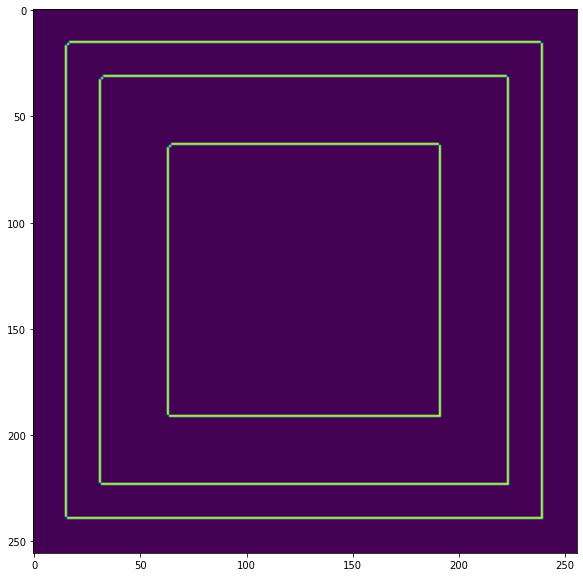

In [6]:
cimg = np.zeros((256, 256), dtype=np.uint8)
cv2.drawContours(cimg, contours, -1, (255,255,255), 1)
plt.imshow(cimg)

In [7]:
print("contours")
print("type: ", type(contours))
print("len: ", len(contours))
print("len(contours[0]): ", len(contours[0]))
print(contours[0])

print()
print()
print()

print("hierarchy")
print("type: ", type(hierarchy))
print("len: ", len(hierarchy))
print("len(hierarchy[0]): ", len(hierarchy[0]))
print(hierarchy[0])

contours
type:  <class 'tuple'>
len:  6
len(contours[0]):  7
[[[ 17  15]]

 [[ 15  17]]

 [[ 15 238]]

 [[ 16 239]]

 [[239 239]]

 [[239  16]]

 [[238  15]]]



hierarchy
type:  <class 'numpy.ndarray'>
len:  1
len(hierarchy[0]):  6
[[-1 -1  1 -1]
 [-1 -1  2  0]
 [-1 -1  3  1]
 [-1 -1  4  2]
 [-1 -1  5  3]
 [-1 -1 -1  4]]


So how do we make sense of this? Drawing them just makes an image of edges, what did we even get with this? How many did we even found? What are these points even? And how do we even interpret the hierarchy matrix?

Here's what the documentation has to say about it:

```
    contours 	 Detected contours. Each contour is stored as a vector of points (e.g. std::vector<std::vector<cv::Point> >).
    hierarchy 	 Optional output vector (e.g. std::vector<cv::Vec4i>), containing information about the image topology. It has as many elements as the number of contours. For each i-th contour contours[i], the elements hierarchy[i][0] , hierarchy[i][1] , hierarchy[i][2] , and hierarchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same hierarchical level, the first child contour and the parent contour, respectively. If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of hierarchy[i] will be negative.

Note
    In Python, hierarchy is nested inside a top level array. Use hierarchy[0][i] to access hierarchical elements of i-th contour. 
```

That doesn't really make sense to me. So I want to demistify the one thing the manual does not do - the layout.

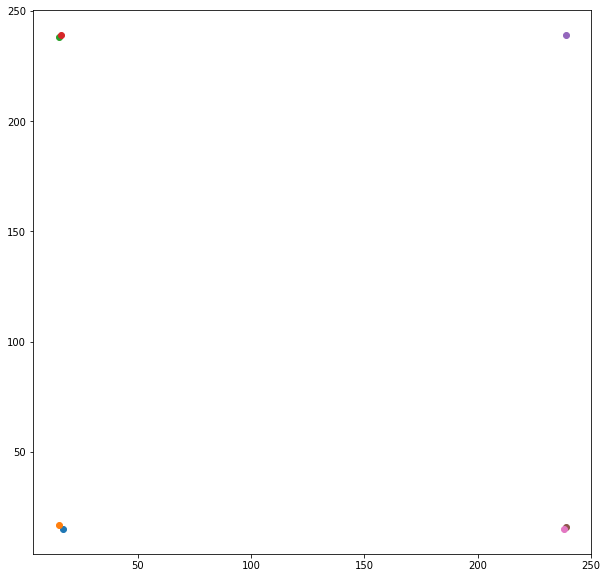

In [8]:
for point in contours[0]:
    plt.scatter(*point[0])

Let's decompose the above for loop. Purely logistically, it looks like we can select the i-th contour by `contours[i]`.       
Since we selected the first contour by `conoturs[0]`, it would reason we would get a list of points like `[ (x1, y1), (x2, y2), ]` so that when we iterate over the array we would get the individual `(x1, y1), (x2, y2)...`.          
However, it seems that what we get is a list of arrays of points, like `[ [(x1, y1)], [(x2, y2)], [(x3, y3)]`. This is evident because we had to access `point[0]`.         
The special operator `*` is called the unpacking operator. Effectively, in code, when you want to pass in an array of values as arguments to a function you can use the unpacking operator. Essentially, it performs the following: `*(x1, x2, x3...) --> x1, x2, x3...`.     
So when we plot `plt.scatter(*(x1, y1)) --> plt.plot(x1, y1)` and that adds a dot in our plot.

So why do we get a list of arrays of point-tuples and does that mean something? In short, no. The reason is that OpenCV is written `C++` and there is some conversion that happens from `C++` types to `Python` types in the code when it returns a value and someone wrote something that made sense in C++ but didn't in Python.      
This is a famous OpenCV "classic" confusion and there's no sense to it. 

Ok, so that means that `len(contours) --> 6` is the number of contours it found. Ok, I guess nobody's perfect. 

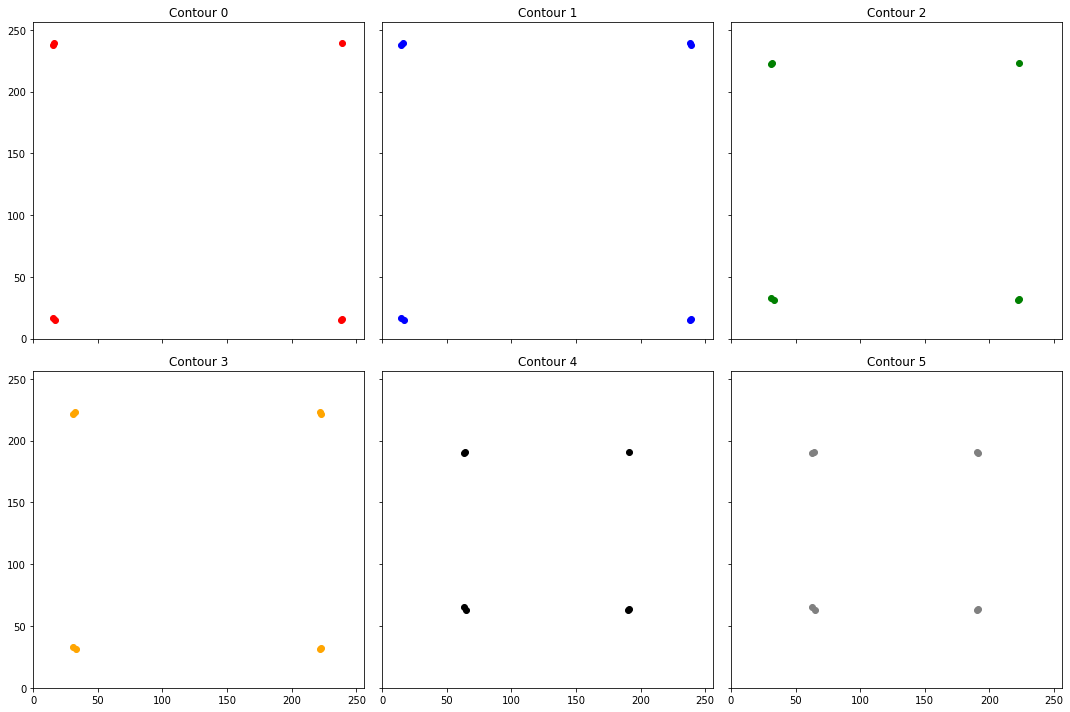

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
i = 0
for ax, cnt, color in zip(axes.ravel(), contours, ("red", "blue", "green", "orange","black", "gray")):
    for point in cnt:
        ax.scatter(*point[0], color=color)
        ax.set_title(f"Contour {i}")
    i+=1
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
plt.tight_layout()

Hmm, interesting! So it found the "same" contours as different contours, with the difference being only a couple of pixels. But of course(!), the countours are lines that track pixels of the same intensity - there is no requirement for this to be a closed curve whatsoever.              
So it has to be that when the algorithm reaches the edges of the squares, where even we can see the pixel intensity is not as large, it fails to properly close the contour and then it basically re-detects multiple different similar contours even after ensuring we have crisp clean borders by using Canny!      
This would also explain why some contours have multiple points on their corners, since the contours would double-back on themselves.

So definitely we need to be careful to properly filter our retrieved contours. So let's. 

Here I basically just went to the tutorial for properties: https://docs.opencv.org/3.4/d1/d32/tutorial_py_contour_properties.html          
Looked up what property I could best take advantage of, decided it was area, and then removed contours of similar areas. 

All areas:  [50173.0, 50172.5, 36861.0, 36860.5, 16381.0, 16380.5]
Duplicate contour:  [False, True, False, True, False, True]
Selected 3 contours, rejected 3 contours as duplicates.


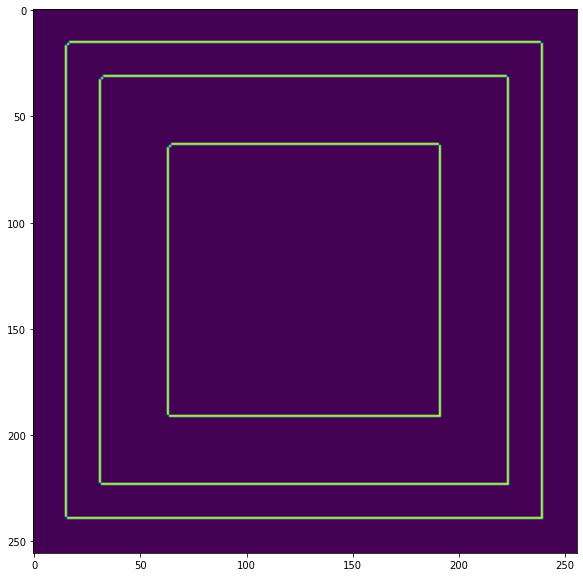

In [10]:
# this just makes life a bit easier
# do note that not all contours have the same number of points 
# and numpy hates this.
contours = np.array(contours, dtype=object)

areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))
print("All areas: ", areas)


# if the contours area are different by more than 5% of
# total image area we consider them different.
dimx, dimy = img.shape
total_image_area = dimx*dimy
area_threshold = 0.1 * total_image_area

# diff gives me the differences between neighbouring elements
# so 1st minus 2nd, 2nd minus 3rd etc...
# We can use this here because we know they are neatly ordered, 
# otherwise we might have to be a bit more clever.
diff = np.abs(np.diff(areas))
same_cnts = diff < area_threshold

# note that our indices will be 1 off because how diff works
duplicates = [False]
duplicates.extend(same_cnts)
print("Duplicate contour: ", duplicates)

# so let's finally select the non-dupes
# note the use of ~ as a NOT operator
contours = contours[np.logical_not(duplicates)]

print(f"Selected {len(contours)} contours, rejected {duplicates.count(True)} contours as duplicates.")
cimg = np.zeros((256, 256), dtype=np.uint8)
cv2.drawContours(cimg, contours, -1, (255,255,255), 1)
plt.imshow(cimg)


## Fitting minimal area rectangles

Let's take a different example, where we can see how poweful knowing moments (f.e. circumference, area, etc..) of our contours can be.

To save us some time repeating the above, I've pre-made a bitmap.

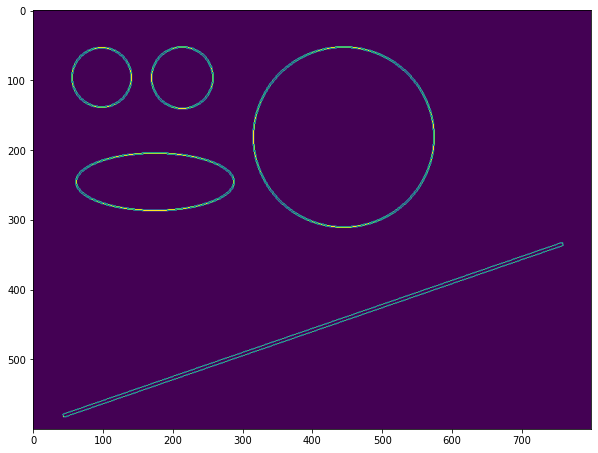

In [11]:
img = cv2.imread("images/bitmap.png", cv2.IMREAD_GRAYSCALE)

contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

cimg = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(cimg, contours, -1, (255,255,255), 1)
plt.imshow(cimg)

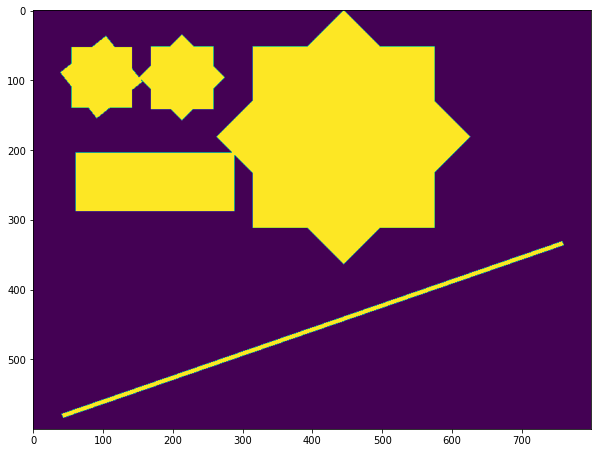

In [12]:
cimg = np.zeros(img.shape, dtype=np.uint8)
treshold = 5

rectangles = []
lines = []
for cnt in contours: 
    rect = cv2.minAreaRect(cnt) # [x, y, w, h, theta]
    rectangles.append(rect)
    
    # let's draw them simultaneously so we save some space
    box = cv2.boxPoints(rect)
    box = np.asarray(box, dtype=np.int32)
    cv2.fillPoly(cimg, [box], (255, 255, 255))
    
    # lines are really long - i.e. one of their sides
    # is much larger than the other. Let's say if
    # one of the sieds is threshold times the other one
    # we reject it!
    (x,y), (w, h), theta = rect
    if (w/h > treshold) or (h/w > treshold):
        lines.append(rect)
    
plt.imshow(cimg)

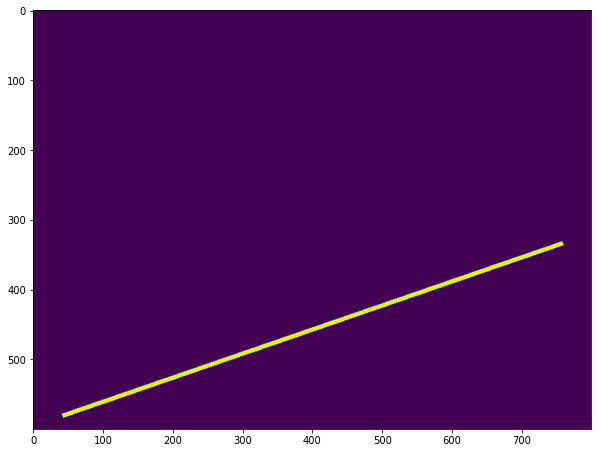

In [13]:
cimg = np.zeros(img.shape, dtype=np.uint8)

for cnt in lines:
    box = cv2.boxPoints(cnt)
    box = np.asarray(box, dtype=np.int32)
    cv2.fillPoly(cimg, [box], (255, 255, 255))    
plt.imshow(cimg)

So you see, contours do give us more information about our objects!

# Summary

* Image segmentation is the process of finding and grouping of pixels into objects and expressing their relations to one another. 
* Contour finding algorithms are a powerful tool for image segmentation
  * This is because they provide shape descriptions and ordering of the detected objects in our image
* Unfortunately they operate only on bitmaps (images with 1 or 0 only)
  * This requires us to either treshold our image beforehand, in such a way we produce edges, or run an edge detection algorithm
  * They can also be somewhat "dirty" - requiring us to filter out duplicates
* All lines on images can be considered as "rectangles" with, at least a minimum side length of 1 pixel
  * Lines are long which means we can use the moments of our contours to find out whether or not the found contour looks like an 
    thin long object or if it's curcular or if etc.. 
  * We can also use these properties to figure out if they are duplicates or not.